In [1]:
import numpy as np
import time
import gym
import torch
import torch.nn as nn
import random
import queue
import matplotlib.pyplot as plt
import math
from IPython.display import clear_output
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
class Env():
    def __init__(self):
        self.env = gym.make('CarRacing-v0')
        self.reward_threshold = self.env.spec.reward_threshold

    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()
        self.die = False
        img_rgb = self.env.reset()
        img_gray = self.rgb2gray(img_rgb)
        self.stack = [img_gray] * 4
        return np.array(self.stack)

    def step(self, action):
        total_reward = 0
        for i in range(8):
            img_rgb, reward, die, _ = self.env.step(action)
            # don't penalize "die state"
            if die:
                reward += 100
            # green penalty
            if np.mean(img_rgb[:, :, 1]) > 185.0:
                reward -= 0.05
            total_reward += reward
            # if no reward recently, end the episode
            done = True if self.av_r(reward) <= -0.1 else False
            if done or die:
                break
        img_gray = self.rgb2gray(img_rgb)
        self.stack.pop(0)
        self.stack.append(img_gray)
        assert len(self.stack) == 4
        return np.array(self.stack), total_reward, done, die

    def render(self):
        self.env.render()

    def close(self):
        self.env.close()
        
    @staticmethod
    def rgb2gray(rgb, norm=True):
        gray = np.dot(rgb[..., :], [0.299, 0.587, 0.114])
        if norm:
            # normalize
            gray = gray / 128. - 1.
        return gray

    @staticmethod
    def reward_memory():
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_base = nn.Sequential(  # input shape (4, 96, 96)
            nn.Conv2d(4, 8, kernel_size=4, stride=2),
            nn.ReLU(),  # activation
            nn.Conv2d(8, 16, kernel_size=3, stride=2),  # (8, 47, 47)
            nn.ReLU(),  # activation
            nn.Conv2d(16, 32, kernel_size=3, stride=2),  # (16, 23, 23)
            nn.ReLU(),  # activation
            nn.Conv2d(32, 64, kernel_size=3, stride=2),  # (32, 11, 11)
            nn.ReLU(),  # activation
            nn.Conv2d(64, 128, kernel_size=3, stride=1),  # (64, 5, 5)
            nn.ReLU(),  # activation
            nn.Conv2d(128, 256, kernel_size=3, stride=1),  # (128, 3, 3)
            nn.ReLU(),  # activation
        )  # output shape (256, 1, 1)
        self.v = nn.Sequential(nn.Linear(256, 100), nn.ReLU(), nn.Linear(100, 1))
        self.fc = nn.Sequential(nn.Linear(256, 100), nn.ReLU())
        self.alpha_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.beta_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.apply(self._weights_init)

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = self.cnn_base(x)
        x = x.view(-1, 256)
        v = self.v(x)
        x = self.fc(x)
        alpha = self.alpha_head(x) + 1
        beta = self.beta_head(x) + 1

        return (alpha, beta), v


class Agent():
    def __init__(self):
        self.net = Net().float().to(device)

    def select_action(self, state):
        state = torch.from_numpy(state).float().to(device).unsqueeze(0)
        with torch.no_grad():
            alpha, beta = self.net(state)[0]
        action = alpha / (alpha + beta)

        action = action.squeeze().cpu().numpy()
        return action

    def load_param(self):
        self.net.load_state_dict(torch.load('param/expert.pkl'))
    
     
class Classifier(nn.Module):
    def __init__(self,ch=2):
        super(Classifier,self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=4,out_channels=ch*8,kernel_size=7),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=ch*8,out_channels=ch*16,kernel_size=5,stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=ch*16,out_channels=ch*32,kernel_size=3,stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=ch*32,out_channels=ch*32,kernel_size=3,stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=ch*32,out_channels=ch*64,kernel_size=3,stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=ch*64,out_channels=ch*64,kernel_size=3,stride=2),
            torch.nn.ReLU()
        )
        self.v = torch.nn.Sequential(
            torch.nn.Linear(64*ch*1*1,256),
            torch.nn.ReLU()
        )
        self.fc = torch.nn.Linear(256,3)
        self.ch = ch
        
    def forward(self,x):
        x = self.layer1(x)
        x = x.view(x.size(0),-1)
        x = self.v(x)
        x = self.fc(x)
        
        x[:,0] = torch.tanh(x[:,0])
        x[:,1] = torch.sigmoid(x[:,1])
        x[:,2] = torch.sigmoid(x[:,2])
        return x

class ImgDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        x = self.X[index]
        y = self.Y[index]
        return x, y

epoch 1
Track generation: 1163..1458 -> 295-tiles track


C:\Users\awds2588\anaconda3\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] 執行緒模式設定後就不能再變更它。
  warnings.warn(str(err))


score: 411.8850340136003
Track generation: 1179..1487 -> 308-tiles track
score: 894.0133550488401
Track generation: 1047..1312 -> 265-tiles track
score: 917.9242424242277
Track generation: 1056..1329 -> 273-tiles track
score: 1035.0999999999863
Track generation: 1043..1336 -> 293-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1029..1296 -> 267-tiles track
score: 901.1030075187804
Track generation: 1078..1359 -> 281-tiles track
score: 895.9714285714132
Track generation: 1119..1403 -> 284-tiles track
score: 906.9321554770179
Track generation: 1025..1285 -> 260-tiles track
score: 910.8559845559688
Track generation: 1048..1314 -> 266-tiles track
score: 906.38490566037
Track generation: 1049..1319 -> 270-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1122..1407 -> 285-tiles track
score: 909.8366197182924
Track generation: 1180..1479 -> 299-tiles track
score: 908.3885

Epoch: 27
BC	mean: 470.46	variance: 199.92
Track generation: 1079..1356 -> 277-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1141..1430 -> 289-tiles track
Epoch: 28
BC	mean: 465.18	variance: 198.23
Track generation: 1159..1453 -> 294-tiles track
Epoch: 29
BC	mean: 472.43	variance: 198.51
Track generation: 1263..1583 -> 320-tiles track
Epoch: 30
BC	mean: 470.54	variance: 195.44
Track generation: 1016..1275 -> 259-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1133..1424 -> 291-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1066..1336 -> 270-tiles track
Epoch: 31
BC	mean: 465.06	variance: 194.59
Track generation: 1120..1404 -> 284-tiles track
Epoch: 32
BC	mean: 466.61	variance: 191.72
Track generation: 1184..1483 -> 299-tiles track
Epoch: 33
BC	mean: 466.93	variance: 188.80
Track generation: 1263..158

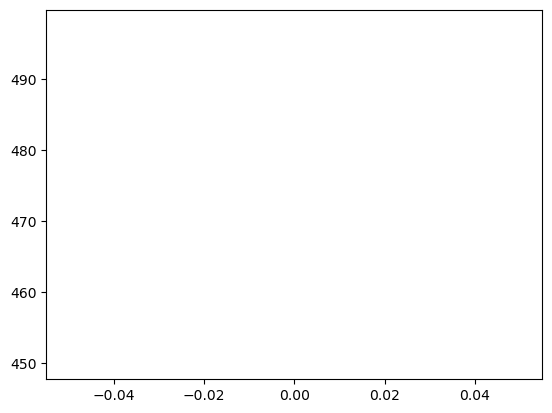

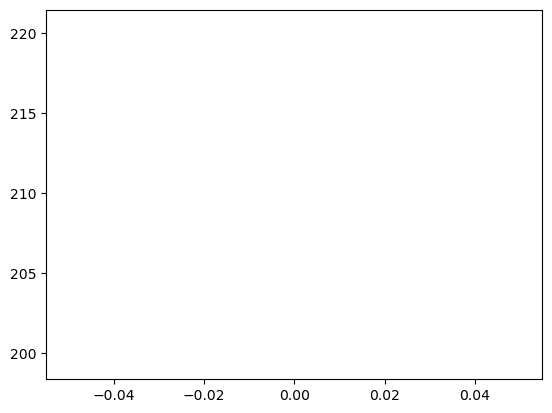

epoch 2
Track generation: 1140..1429 -> 289-tiles track
score: 1026.8999999999833
Track generation: 1111..1386 -> 275-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 972..1219 -> 247-tiles track
score: 1042.1999999999975
Track generation: 1074..1353 -> 279-tiles track
score: 1027.7999999999865
Track generation: 1203..1508 -> 305-tiles track
score: 896.9421052631416
Track generation: 1146..1437 -> 291-tiles track
score: 898.7586206896387
Track generation: 1192..1503 -> 311-tiles track
score: 1013.0999999999916
Track generation: 1120..1404 -> 284-tiles track
score: 1032.8999999999878
Track generation: 1172..1469 -> 297-tiles track
score: 904.1864864864677
Track generation: 1091..1373 -> 282-tiles track
score: 912.4825622775695
Track generation: 1128..1414 -> 286-tiles track
score: 1025.899999999985
Dataset size: 3746
[001/010] 1.32 sec(s) Train Loss: 0.000052 | Val loss: 0.000037
[002/010] 1.16 sec(s) Train Loss: 0.000031 | Va

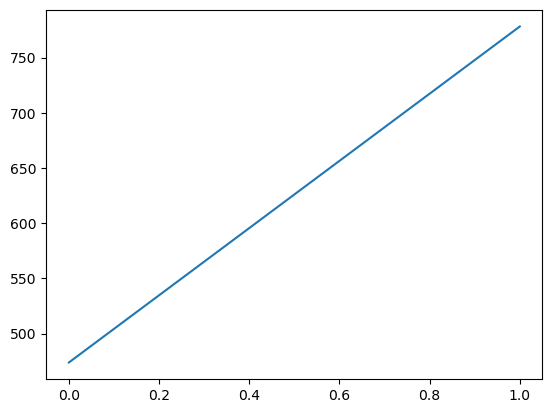

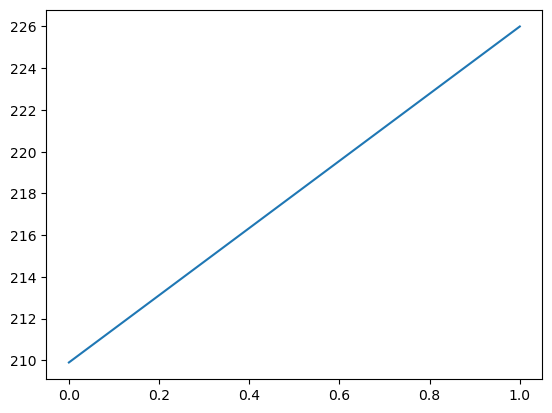

epoch 3
Track generation: 1170..1469 -> 299-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1152..1452 -> 300-tiles track
score: 847.8214046822584
Track generation: 1250..1567 -> 317-tiles track
score: 875.3189873417608
Track generation: 1248..1564 -> 316-tiles track
score: 892.2269841269649
Track generation: 1168..1465 -> 297-tiles track
score: 885.6729729729534
Track generation: 1192..1500 -> 308-tiles track
score: 896.5706840390686
Track generation: 1300..1629 -> 329-tiles track
score: 1016.9999999999833
Track generation: 1225..1541 -> 316-tiles track
score: 1014.599999999983
Track generation: 1211..1517 -> 306-tiles track
score: 910.0213114753963
Track generation: 936..1180 -> 244-tiles track
score: 1039.7999999999943
Track generation: 1091..1368 -> 277-tiles track
score: 1040.5999999999958
Dataset size: 4774
[001/010] 1.65 sec(s) Train Loss: 0.000040 | Val loss: 0.000031
[002/010] 1.42 sec(s) Train Loss: 0.000030 | Val 

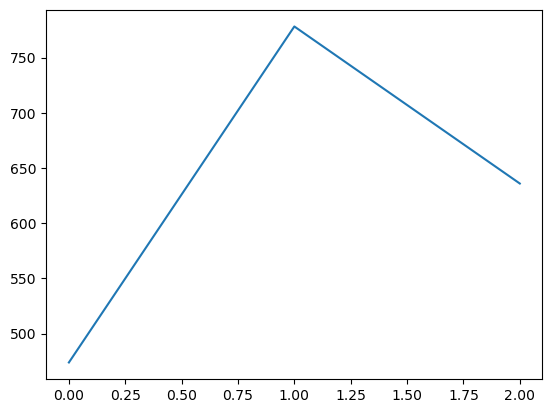

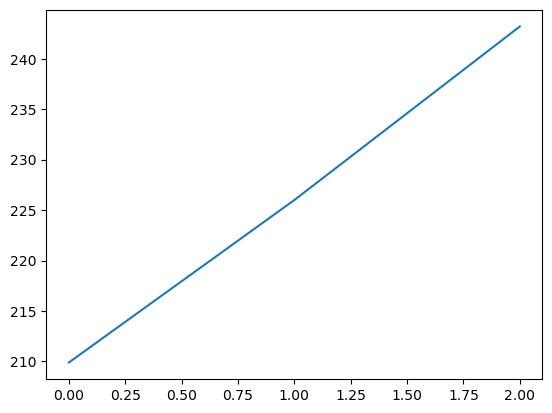

epoch 4
Track generation: 1093..1369 -> 276-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1117..1408 -> 291-tiles track
score: 1027.5999999999872
Track generation: 1237..1550 -> 313-tiles track
score: 888.7641025640867
Track generation: 1064..1334 -> 270-tiles track
score: 1037.399999999991
Track generation: 1106..1387 -> 281-tiles track
score: 1027.5999999999858
Track generation: 1061..1330 -> 269-tiles track
score: 899.9119402984924
Track generation: 1172..1469 -> 297-tiles track
score: 1023.799999999983
Track generation: 1180..1482 -> 302-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1178..1483 -> 305-tiles track
score: 875.5947368420894
Track generation: 1232..1544 -> 312-tiles track
score: 888.4919614147752
Track generation: 1092..1369 -> 277-tiles track
score: 913.3304347826006
Track generation: 1051..1318 -> 267-tiles track
score: 1039.8999999999874
Dat

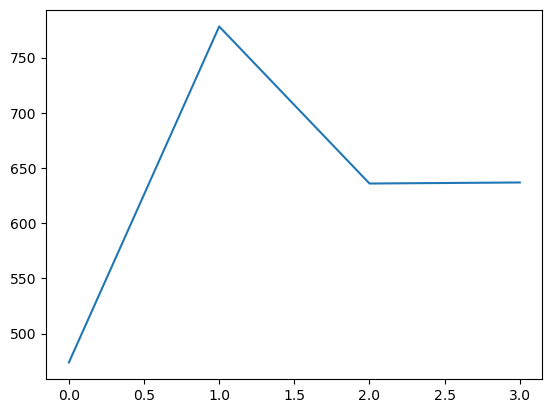

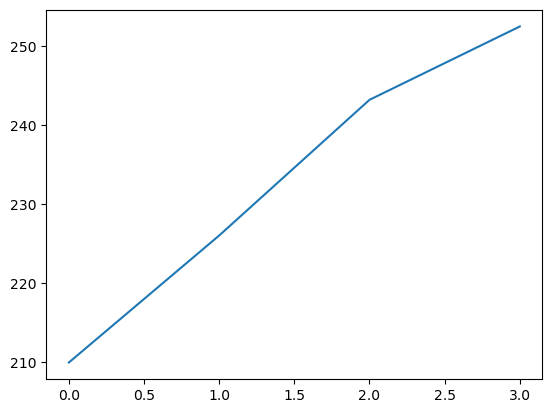

epoch 5
Track generation: 1248..1564 -> 316-tiles track
score: 900.3761904761714
Track generation: 1175..1473 -> 298-tiles track
score: 872.8959595959421
Track generation: 1188..1489 -> 301-tiles track
score: 915.2666666666574
Track generation: 1168..1464 -> 296-tiles track
score: 889.0711864406632
Track generation: 1087..1364 -> 277-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1111..1393 -> 282-tiles track
score: 324.30676156583144
Track generation: 1149..1440 -> 291-tiles track
score: 901.1034482758438
Track generation: 1076..1349 -> 273-tiles track
score: 909.870588235277
Track generation: 1119..1403 -> 284-tiles track
score: 915.9328621907983
Track generation: 1043..1313 -> 270-tiles track
score: 1031.1999999999907
Track generation: 1143..1433 -> 290-tiles track
score: 899.538754325251
Dataset size: 6672
[001/010] 2.13 sec(s) Train Loss: 0.000038 | Val loss: 0.000027
[002/010] 2.01 sec(s) Train Loss: 0.000027 | Val lo

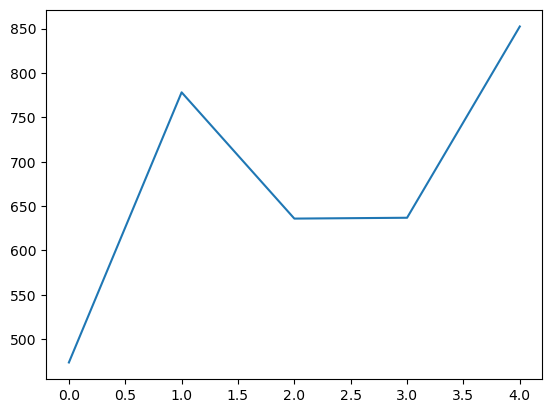

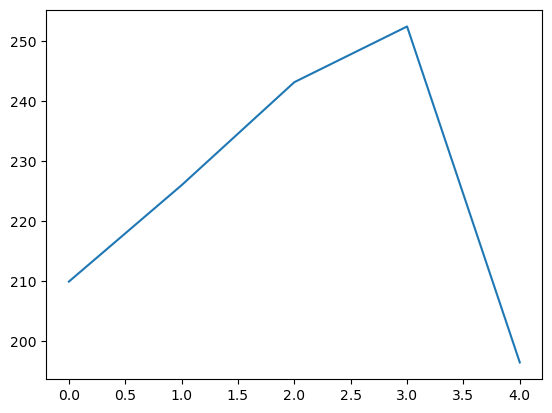

epoch 6
Track generation: 991..1243 -> 252-tiles track
score: 1038.2999999999952
Track generation: 1092..1369 -> 277-tiles track
score: 892.4376811594105
Track generation: 1019..1278 -> 259-tiles track
score: 1038.6999999999962
Track generation: 1039..1303 -> 264-tiles track
score: 1034.2999999999847
Track generation: 1087..1363 -> 276-tiles track
score: 912.4909090908945
Track generation: 1081..1349 -> 268-tiles track
score: 868.3561797752684
Track generation: 1136..1424 -> 288-tiles track
score: 895.5097560975478
Track generation: 1060..1329 -> 269-tiles track
score: 916.8059701492398
Track generation: 1133..1427 -> 294-tiles track
score: 890.2092150170473
Track generation: 1251..1568 -> 317-tiles track
score: 1019.4999999999927
Dataset size: 7618
[001/010] 2.42 sec(s) Train Loss: 0.000035 | Val loss: 0.000025
[002/010] 2.26 sec(s) Train Loss: 0.000025 | Val loss: 0.000025
[003/010] 2.27 sec(s) Train Loss: 0.000024 | Val loss: 0.000024
[004/010] 2.26 sec(s) Train Loss: 0.000025 | Val

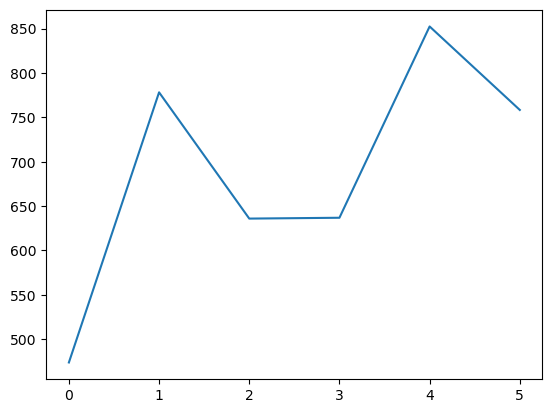

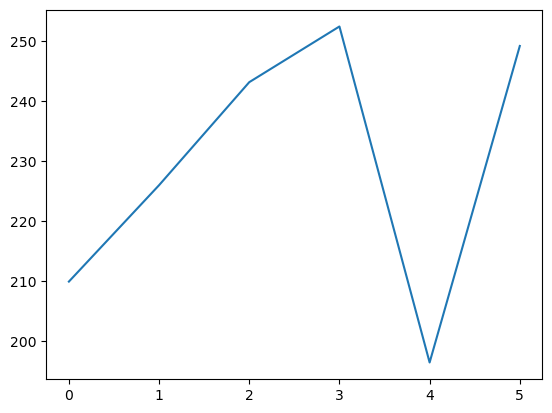

epoch 7
Track generation: 1024..1291 -> 267-tiles track
score: 1033.0999999999867
Track generation: 1075..1348 -> 273-tiles track
score: 896.2647058823361
Track generation: 1102..1381 -> 279-tiles track
score: 1028.7999999999856
Track generation: 1151..1443 -> 292-tiles track
score: 1025.999999999984
Track generation: 1232..1544 -> 312-tiles track
score: 909.6845659163831
Track generation: 1221..1530 -> 309-tiles track
score: 759.915584415571
Track generation: 1201..1505 -> 304-tiles track
score: 900.4986798679769
Track generation: 1199..1503 -> 304-tiles track
score: 1024.6999999999925
Track generation: 1193..1495 -> 302-tiles track
score: 903.038704318929
Track generation: 1108..1401 -> 293-tiles track
score: 904.4260273972437
Dataset size: 8591
[001/010] 2.75 sec(s) Train Loss: 0.000031 | Val loss: 0.000026
[002/010] 2.57 sec(s) Train Loss: 0.000024 | Val loss: 0.000027
[003/010] 2.61 sec(s) Train Loss: 0.000024 | Val loss: 0.000024
[004/010] 2.62 sec(s) Train Loss: 0.000023 | Val l

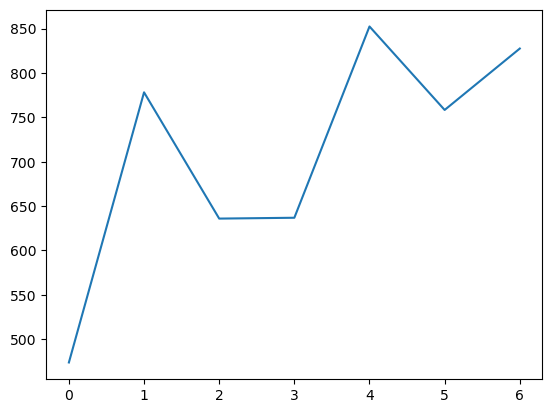

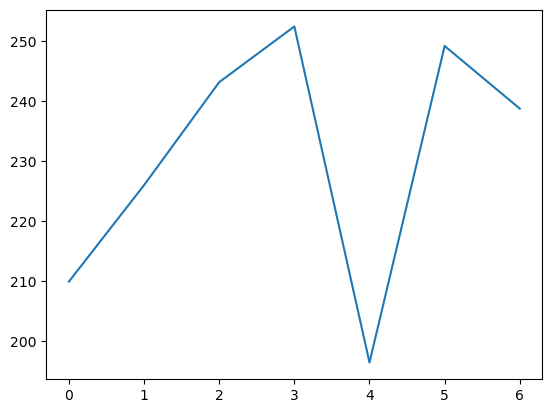

epoch 8
Track generation: 1031..1293 -> 262-tiles track
score: 1042.299999999997
Track generation: 1261..1580 -> 319-tiles track
score: 865.2194968553251
Track generation: 1011..1271 -> 260-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1107..1388 -> 281-tiles track
score: 916.7571428571281
Track generation: 1108..1397 -> 289-tiles track
score: 1024.2999999999836
Track generation: 1267..1588 -> 321-tiles track
score: 906.0499999999864
Track generation: 1171..1468 -> 297-tiles track
score: 906.664864864846
Track generation: 1129..1415 -> 286-tiles track
score: 913.7649122806873
Track generation: 1198..1502 -> 304-tiles track
score: 1025.299999999993
Track generation: 1105..1386 -> 281-tiles track
score: 905.1857142856977
Track generation: 1092..1370 -> 278-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1087..1367 -> 280-tiles track
retry to generate track (normal

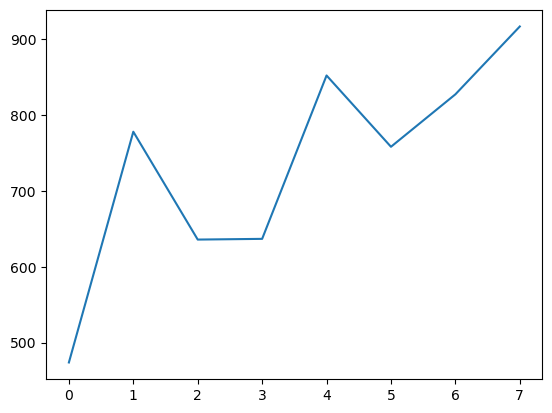

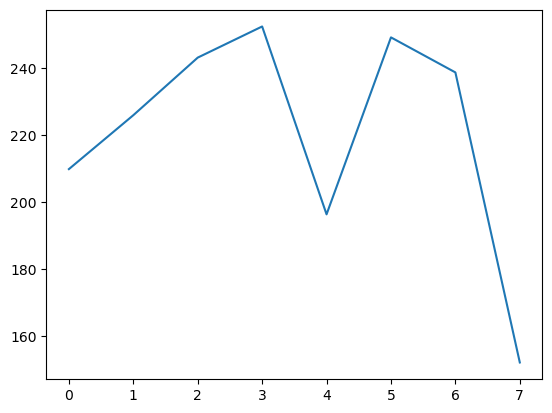

epoch 9
Track generation: 1243..1558 -> 315-tiles track
score: 310.2337579617804
Track generation: 1072..1344 -> 272-tiles track
score: 914.3298892988846
Track generation: 1215..1522 -> 307-tiles track
score: 883.5562091503054
Track generation: 1128..1414 -> 286-tiles track
score: 1026.7999999999852
Track generation: 1151..1443 -> 292-tiles track
score: 913.9635738831439
Track generation: 978..1231 -> 253-tiles track
score: 1036.3999999999926
Track generation: 1151..1449 -> 298-tiles track
score: 898.265993265975
Track generation: 1227..1538 -> 311-tiles track
score: 1025.099999999993
Track generation: 1155..1448 -> 293-tiles track
score: 1029.9999999999852
Track generation: 1228..1539 -> 311-tiles track
score: 898.3967741935385
Dataset size: 10485
[001/010] 3.46 sec(s) Train Loss: 0.000028 | Val loss: 0.000022
[002/010] 3.25 sec(s) Train Loss: 0.000021 | Val loss: 0.000020
[003/010] 3.30 sec(s) Train Loss: 0.000021 | Val loss: 0.000023
[004/010] 3.21 sec(s) Train Loss: 0.000021 | Val 

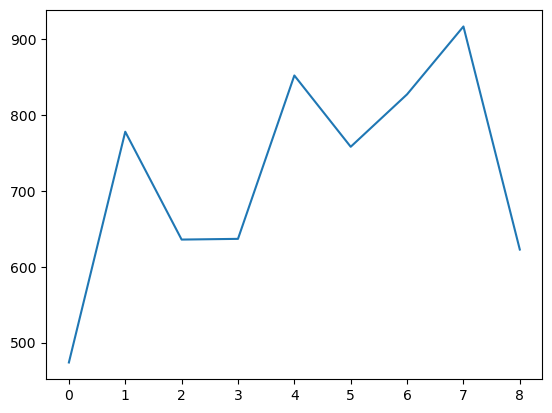

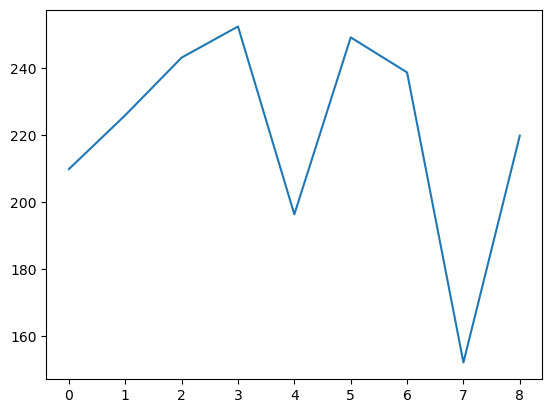

epoch 10
Track generation: 1032..1294 -> 262-tiles track
score: 1037.699999999996
Track generation: 1115..1398 -> 283-tiles track
score: 909.7156028368692
Track generation: 1131..1418 -> 287-tiles track
score: 915.7104895104758
Track generation: 1088..1364 -> 276-tiles track
score: 902.3181818181667
Track generation: 1168..1468 -> 300-tiles track
score: 1024.5999999999835
Track generation: 1299..1628 -> 329-tiles track
score: 871.5121951219307
Track generation: 1105..1391 -> 286-tiles track
score: 898.3649122806855
Track generation: 1216..1524 -> 308-tiles track
score: 1019.2999999999813
Track generation: 1183..1483 -> 300-tiles track
score: 893.4886287625231
Track generation: 1027..1290 -> 263-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1046..1312 -> 266-tiles track
score: 1035.4999999999936
Dataset size: 11466
[001/010] 3.94 sec(s) Train Loss: 0.000024 | Val loss: 0.000018
[002/010] 3.65 sec(s) Train Loss: 0.000019 | V

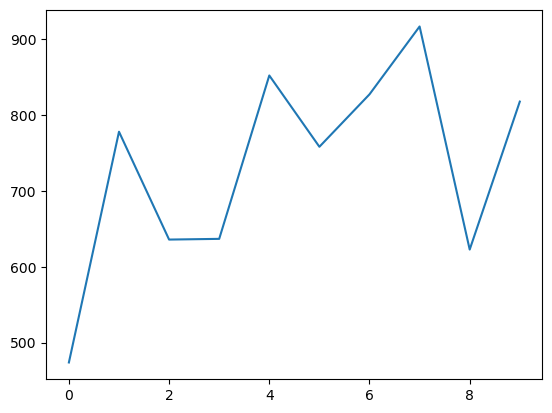

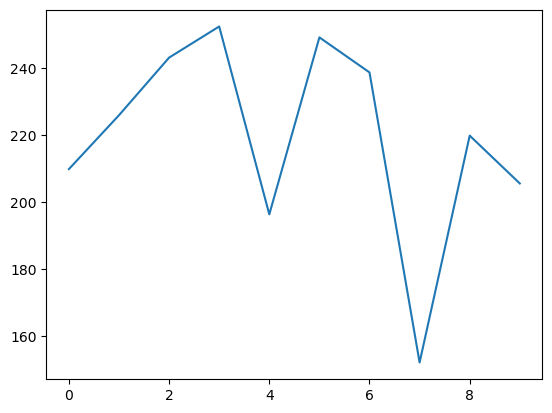

epoch 11
Track generation: 1111..1393 -> 282-tiles track
score: 894.330249110309
Track generation: 1129..1415 -> 286-tiles track
score: 900.1561403508607
Track generation: 1155..1448 -> 293-tiles track
score: 912.2753424657354
Track generation: 1081..1356 -> 275-tiles track
score: 1030.8999999999855
Track generation: 1007..1263 -> 256-tiles track
score: 1037.6999999999864
Track generation: 1127..1413 -> 286-tiles track
score: 1031.5999999999867
Track generation: 1219..1528 -> 309-tiles track
score: 1022.4999999999832
Track generation: 1407..1763 -> 356-tiles track
score: 745.4366197182919
Track generation: 1108..1389 -> 281-tiles track
score: 1032.199999999987
Track generation: 1208..1514 -> 306-tiles track
score: 1018.3999999999876
Dataset size: 12425
[001/010] 4.29 sec(s) Train Loss: 0.000023 | Val loss: 0.000024
[002/010] 3.91 sec(s) Train Loss: 0.000019 | Val loss: 0.000020
[003/010] 3.81 sec(s) Train Loss: 0.000019 | Val loss: 0.000019
[004/010] 4.09 sec(s) Train Loss: 0.000018 | 

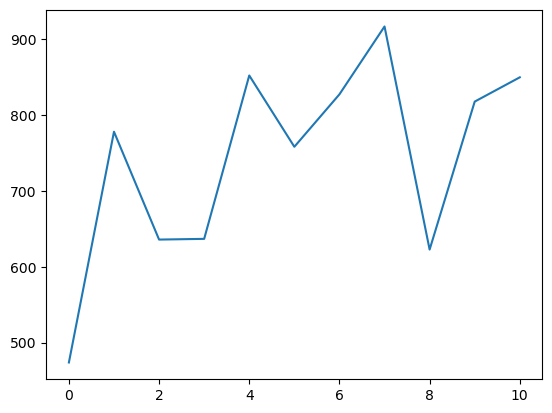

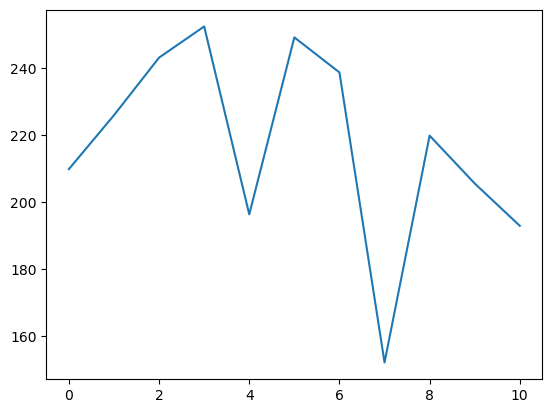

epoch 12
Track generation: 1131..1419 -> 288-tiles track
score: 1026.199999999988
Track generation: 1108..1389 -> 281-tiles track
score: 903.4142857142696
Track generation: 1120..1404 -> 284-tiles track
score: 878.3307420494547
Track generation: 1129..1400 -> 271-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1231..1543 -> 312-tiles track
score: 861.9839228295658
Track generation: 1096..1374 -> 278-tiles track
score: 916.169675090247
Track generation: 1231..1543 -> 312-tiles track
score: 1023.699999999987
Track generation: 1067..1338 -> 271-tiles track
score: 1036.0999999999888
Track generation: 1174..1474 -> 300-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1054..1322 -> 268-tiles track
score: 922.3546816479306
Track generation: 1220..1538 -> 318-tiles track
score: 1019.2999999999905
Track generation: 1192..1495 -> 303-tiles track
score: 873.7874172185338
Data

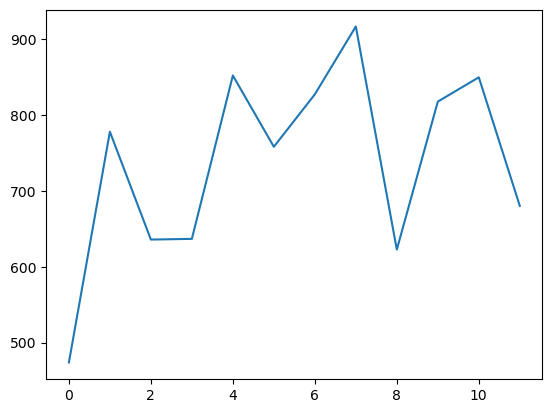

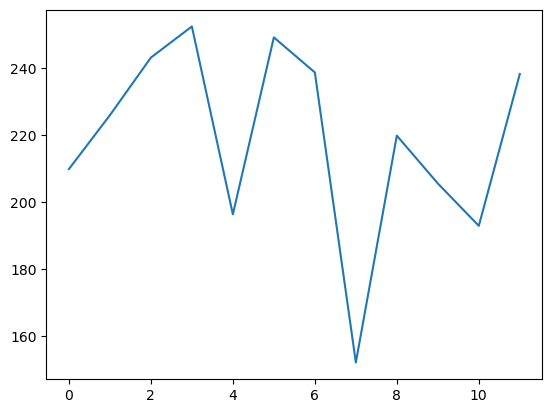

epoch 13
Track generation: 1051..1324 -> 273-tiles track
score: 1031.5999999999854
Track generation: 1237..1550 -> 313-tiles track
score: 907.4897435897283
Track generation: 1168..1464 -> 296-tiles track
score: 907.7305084745626
Track generation: 1109..1390 -> 281-tiles track
score: 1033.0999999999872
Track generation: 1188..1493 -> 305-tiles track
score: 901.7315789473528
Track generation: 1136..1424 -> 288-tiles track
score: 1026.5999999999885
Track generation: 1171..1468 -> 297-tiles track
score: 1027.6999999999834
Track generation: 1122..1413 -> 291-tiles track
score: 914.5517241379165
Track generation: 1294..1621 -> 327-tiles track
score: 895.2975460122575
Track generation: 1003..1263 -> 260-tiles track
score: 910.9559845559696
Dataset size: 14411
[001/010] 4.72 sec(s) Train Loss: 0.000019 | Val loss: 0.000017
[002/010] 4.63 sec(s) Train Loss: 0.000017 | Val loss: 0.000020
[003/010] 4.44 sec(s) Train Loss: 0.000017 | Val loss: 0.000018
[004/010] 4.62 sec(s) Train Loss: 0.000016 | 

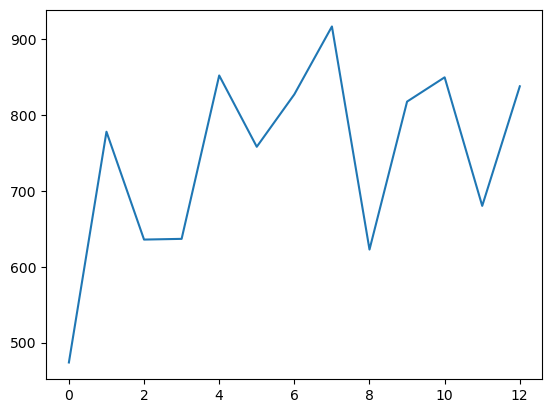

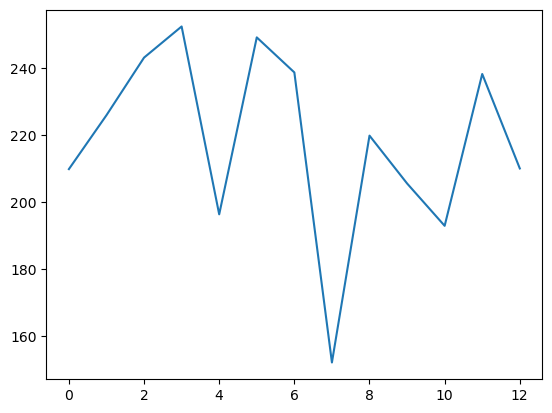

epoch 14
Track generation: 1108..1396 -> 288-tiles track
score: 901.0470383275122
Track generation: 1218..1530 -> 312-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1343..1683 -> 340-tiles track
score: 1010.3999999999925
Track generation: 1145..1436 -> 291-tiles track
score: 910.503448275846
Track generation: 1023..1287 -> 264-tiles track
score: 1032.199999999985
Track generation: 1041..1314 -> 273-tiles track
score: 912.5705882352792
Track generation: 1057..1330 -> 273-tiles track
score: 1033.5999999999858
Track generation: 1100..1380 -> 280-tiles track
score: 904.9630824372628
Track generation: 995..1252 -> 257-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1181..1480 -> 299-tiles track
score: 1024.6999999999848
Track generation: 1018..1284 -> 266-tiles track
score: 1032.6999999999935
Track generation: 1136..1424 -> 288-tiles track
score: 1025.9999999999882
Da

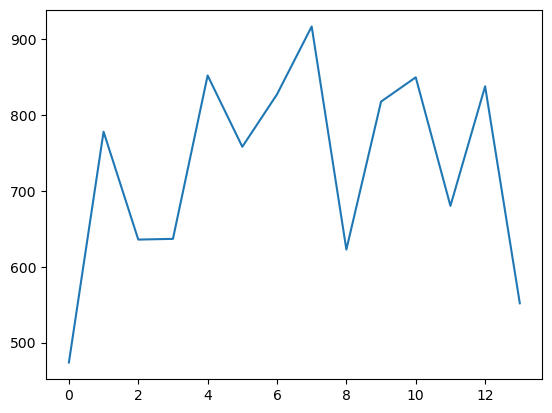

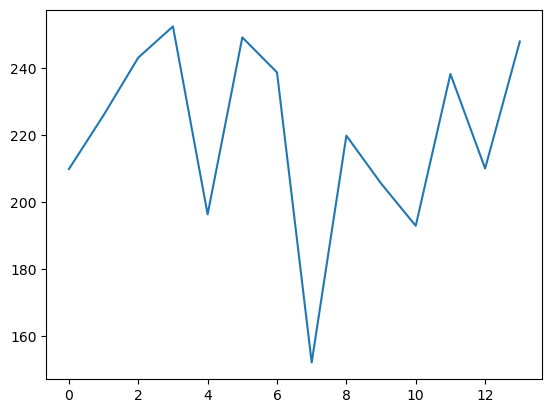

epoch 15
Track generation: 1161..1455 -> 294-tiles track
score: 1028.199999999984
Track generation: 1121..1408 -> 287-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1300..1629 -> 329-tiles track
score: 1016.6999999999831
Track generation: 1284..1609 -> 325-tiles track
score: 896.854320987635
Track generation: 921..1158 -> 237-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1140..1429 -> 289-tiles track
score: 892.8944444444257
Track generation: 1304..1634 -> 330-tiles track
score: 987.8419452887385
Track generation: 1091..1368 -> 277-tiles track
score: 916.5536231883975
Track generation: 1263..1583 -> 320-tiles track
score: 1019.0999999999807
Track generation: 1339..1678 -> 339-tiles track
score: 891.8242603550085
Track generation: 1226..1537 -> 311-tiles track
score: 1023.0999999999929
Track generation: 1115..1398 -> 283-tiles track
score: 1031.8999999999915
Dat

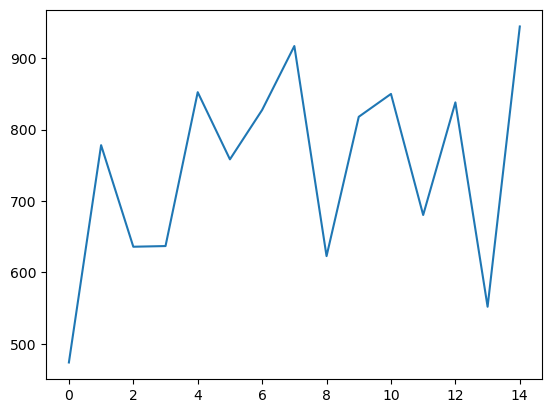

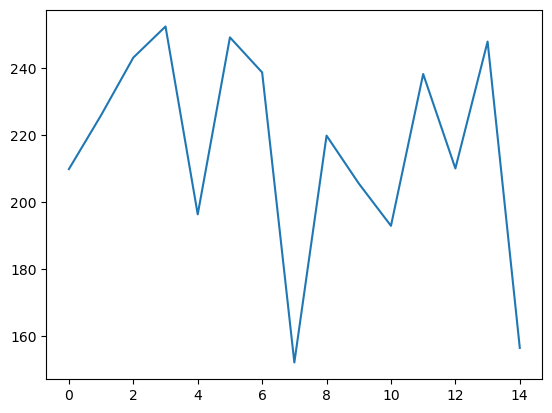

epoch 16
Track generation: 1145..1442 -> 297-tiles track
score: 1024.2999999999834
Track generation: 1212..1519 -> 307-tiles track
score: 892.1241830065159
Track generation: 1146..1436 -> 290-tiles track
score: 913.9795847750784
Track generation: 1128..1414 -> 286-tiles track
score: 891.7385964912112
Track generation: 1178..1477 -> 299-tiles track
score: 1024.3999999999844
Track generation: 1040..1311 -> 271-tiles track
score: 1028.699999999988
Track generation: 993..1245 -> 252-tiles track
score: 905.1956175298732
Track generation: 975..1223 -> 248-tiles track
score: 1042.5999999999876
Track generation: 1264..1584 -> 320-tiles track
score: 1018.1999999999806
Track generation: 1208..1514 -> 306-tiles track
score: 886.370491803265
Dataset size: 17385
[001/010] 5.45 sec(s) Train Loss: 0.000018 | Val loss: 0.000015
[002/010] 5.28 sec(s) Train Loss: 0.000015 | Val loss: 0.000015
[003/010] 5.31 sec(s) Train Loss: 0.000015 | Val loss: 0.000017
[004/010] 5.29 sec(s) Train Loss: 0.000014 | Val

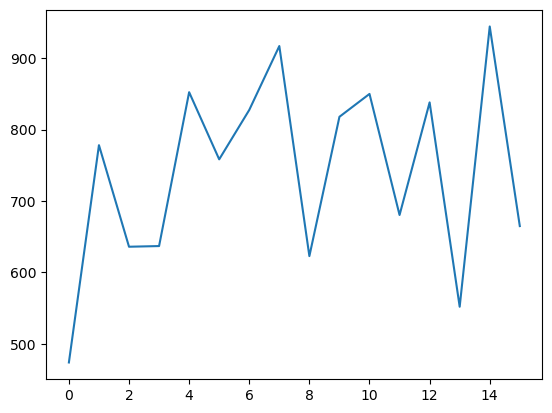

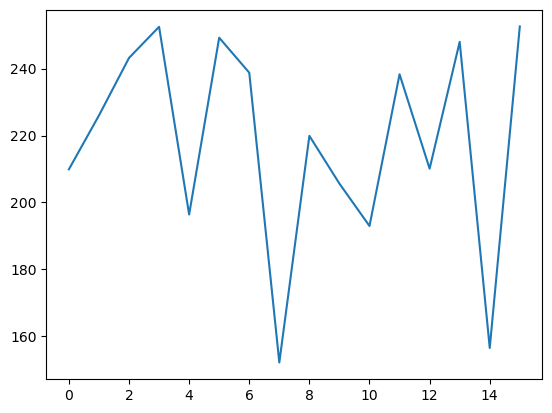

epoch 17
Track generation: 1099..1378 -> 279-tiles track
score: 1031.1999999999862
Track generation: 1043..1308 -> 265-tiles track
score: 1032.199999999987
Track generation: 1047..1313 -> 266-tiles track
score: 907.3320754716893
Track generation: 1259..1585 -> 326-tiles track
score: 885.638461538451
Track generation: 1163..1458 -> 295-tiles track
score: 1025.1999999999935
Track generation: 1227..1545 -> 318-tiles track
score: 1012.6999999999888
Track generation: 1248..1564 -> 316-tiles track
score: 1020.6999999999832
Track generation: 1195..1498 -> 303-tiles track
score: 896.8549668874062
Track generation: 1143..1434 -> 291-tiles track
score: 1028.1999999999866
Track generation: 1063..1333 -> 270-tiles track
score: 900.4776951672749
Dataset size: 18368
[001/010] 5.97 sec(s) Train Loss: 0.000016 | Val loss: 0.000014
[002/010] 5.77 sec(s) Train Loss: 0.000015 | Val loss: 0.000015
[003/010] 5.79 sec(s) Train Loss: 0.000014 | Val loss: 0.000016
[004/010] 5.71 sec(s) Train Loss: 0.000015 | 

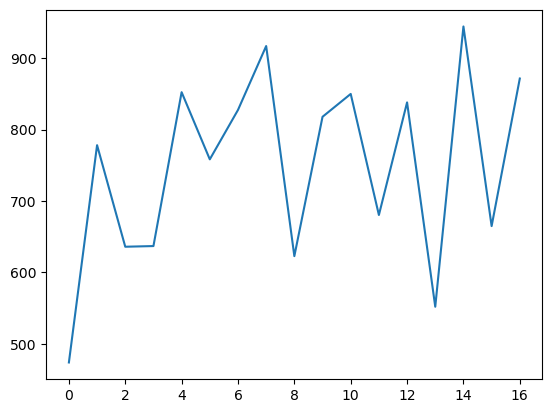

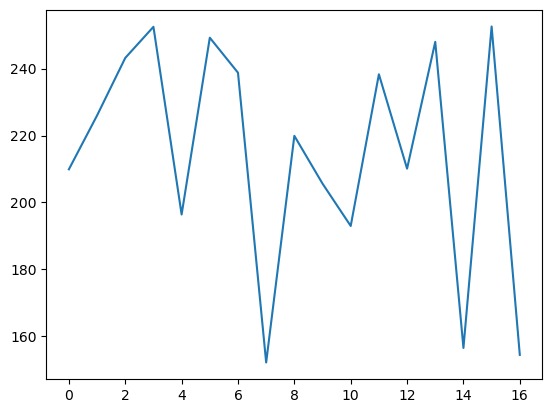

epoch 18
Track generation: 1012..1277 -> 265-tiles track
score: 1031.6999999999875
Track generation: 1080..1354 -> 274-tiles track
score: 897.9589743589648
Track generation: 1082..1357 -> 275-tiles track
score: 735.8197080291853
Track generation: 1153..1445 -> 292-tiles track
score: 884.508591065275
Track generation: 1127..1419 -> 292-tiles track
score: 910.0271477663066
Track generation: 1127..1420 -> 293-tiles track
score: 904.2260273972435
Track generation: 1195..1498 -> 303-tiles track
score: 902.1549668874075
Track generation: 1130..1415 -> 285-tiles track
score: 1030.499999999986
Track generation: 1107..1388 -> 281-tiles track
score: 909.9571428571264
Track generation: 1178..1484 -> 306-tiles track
score: 899.7639344262168
Dataset size: 19365
[001/010] 6.42 sec(s) Train Loss: 0.000016 | Val loss: 0.000019
[002/010] 5.91 sec(s) Train Loss: 0.000015 | Val loss: 0.000016
[003/010] 5.98 sec(s) Train Loss: 0.000015 | Val loss: 0.000022
[004/010] 6.14 sec(s) Train Loss: 0.000016 | Val 

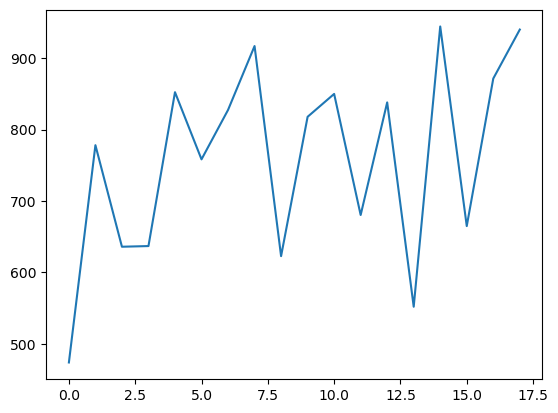

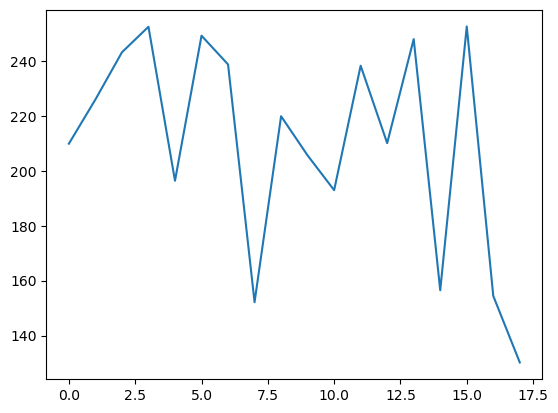

epoch 19
Track generation: 1171..1468 -> 297-tiles track
score: 1031.3999999999846
Track generation: 1088..1364 -> 276-tiles track
score: 1030.5999999999872
Track generation: 1108..1389 -> 281-tiles track
score: 905.2428571428421
Track generation: 1016..1283 -> 267-tiles track
score: 1034.0999999999872
Track generation: 1137..1425 -> 288-tiles track
score: 891.1754355400562
Track generation: 1232..1547 -> 315-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1170..1469 -> 299-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1240..1554 -> 314-tiles track
score: 1021.8999999999894
Track generation: 1142..1431 -> 289-tiles track
score: 905.2833333333142
Track generation: 1119..1403 -> 284-tiles track
score: 915.166431095391
Track generation: 1244..1558 -> 314-tiles track
score: 894.0255591054181
Track generation: 1089..1365 -> 276-tiles track
score: 905.6545454545303
Da

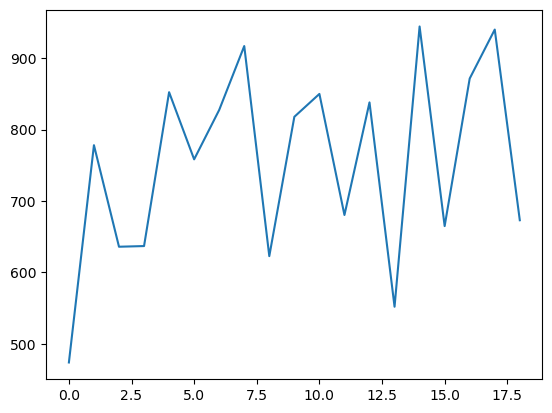

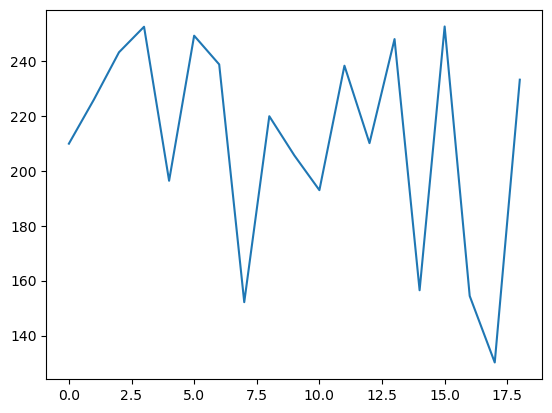

epoch 20
Track generation: 1138..1435 -> 297-tiles track
score: 904.9648648648472
Track generation: 1244..1559 -> 315-tiles track
score: 886.9070063694065
Track generation: 1004..1259 -> 255-tiles track
score: 911.4149606299136
Track generation: 1136..1424 -> 288-tiles track
score: 1032.3999999999896
Track generation: 1115..1398 -> 283-tiles track
score: 911.4617021276488
Track generation: 1065..1338 -> 273-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 982..1234 -> 252-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 989..1242 -> 253-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1173..1471 -> 298-tiles track
score: 1028.0999999999858
Track generation: 999..1253 -> 254-tiles track
score: 1037.5999999999947
Track generation: 1036..1299 -> 263-tiles track
score: 744.9603053435042
Track generation: 1105.

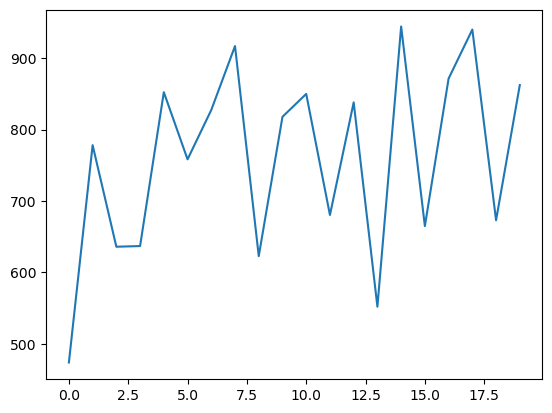

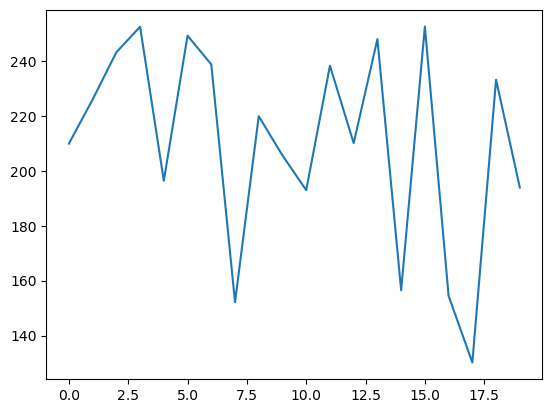

epoch 21
Track generation: 1035..1303 -> 268-tiles track
score: 1030.4999999999923
Track generation: 1128..1414 -> 286-tiles track
score: 1027.8999999999855
Track generation: 1135..1423 -> 288-tiles track
score: 1029.599999999989
Track generation: 1170..1466 -> 296-tiles track
score: 893.1406779660864
Track generation: 1112..1394 -> 282-tiles track
score: 896.3889679715186
Track generation: 1121..1405 -> 284-tiles track
score: 1030.6999999999873
Track generation: 1204..1510 -> 306-tiles track
score: 1019.2999999999879
Track generation: 1077..1353 -> 276-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1252..1569 -> 317-tiles track
score: 1018.4999999999924
Track generation: 1268..1598 -> 330-tiles track
score: 1014.8999999999896
Track generation: 1248..1564 -> 316-tiles track
score: 891.226984126965
Dataset size: 22301
[001/010] 7.11 sec(s) Train Loss: 0.000015 | Val loss: 0.000014
[002/010] 6.82 sec(s) Train Loss: 0.000014 |

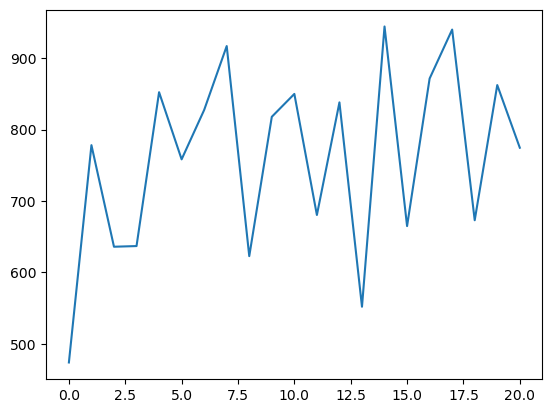

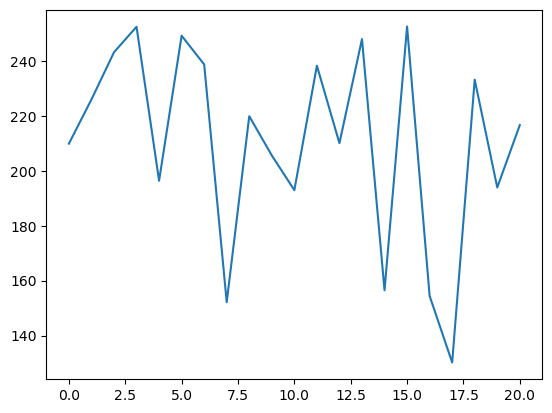

epoch 22
Track generation: 1107..1388 -> 281-tiles track
score: 1027.899999999986
Track generation: 1127..1413 -> 286-tiles track
score: 906.3736842105094
Track generation: 1251..1567 -> 316-tiles track
score: 874.4285714285513
Track generation: 1247..1563 -> 316-tiles track
score: 911.7253968253789
Track generation: 1106..1394 -> 288-tiles track
score: 908.2470383275139
Track generation: 1132..1419 -> 287-tiles track
score: 1029.699999999987
Track generation: 1186..1496 -> 310-tiles track
score: 903.5637540452914
Track generation: 1111..1400 -> 289-tiles track
score: 885.5222222222044
Track generation: 997..1243 -> 246-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1111..1393 -> 282-tiles track
score: 1030.8999999999905
Track generation: 1115..1398 -> 283-tiles track
score: 913.357801418429
Dataset size: 23326
[001/010] 7.36 sec(s) Train Loss: 0.000015 | Val loss: 0.000013
[002/010] 7.33 sec(s) Train Loss: 0.000014 | Val l

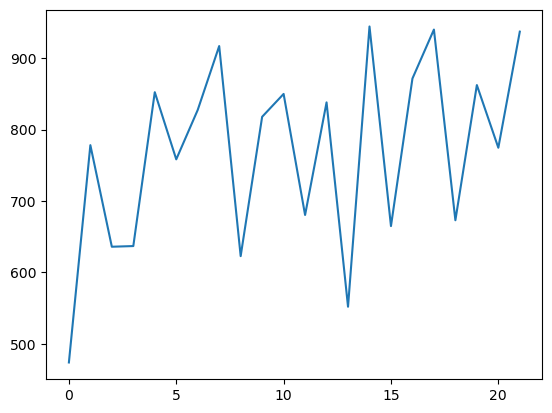

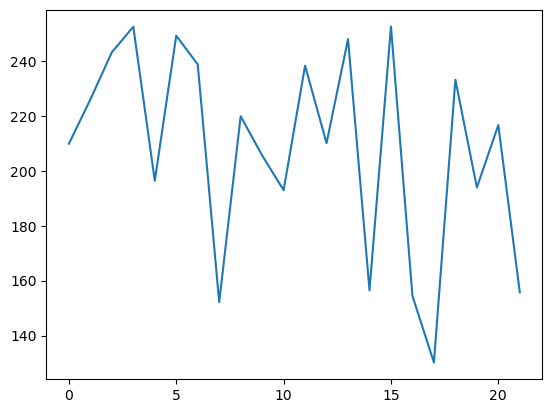

epoch 23
Track generation: 1307..1638 -> 331-tiles track
score: 640.7121212121051
Track generation: 1179..1478 -> 299-tiles track
score: 909.9885906040097
Track generation: 1027..1288 -> 261-tiles track
score: 877.146153846139
Track generation: 1021..1286 -> 265-tiles track
score: 1038.599999999989
Track generation: 1260..1580 -> 320-tiles track
score: 890.4608150469993
Track generation: 1256..1574 -> 318-tiles track
score: 1022.9999999999905
Track generation: 1269..1589 -> 320-tiles track
score: 891.8608150469998
Track generation: 1002..1262 -> 260-tiles track
score: 1037.199999999987
Track generation: 983..1238 -> 255-tiles track
score: 914.4259842519591
Track generation: 1003..1258 -> 255-tiles track
score: 1038.2999999999938
Dataset size: 24299
[001/010] 7.90 sec(s) Train Loss: 0.000015 | Val loss: 0.000016
[002/010] 7.60 sec(s) Train Loss: 0.000014 | Val loss: 0.000016
[003/010] 7.64 sec(s) Train Loss: 0.000014 | Val loss: 0.000014
[004/010] 7.61 sec(s) Train Loss: 0.000013 | Val 

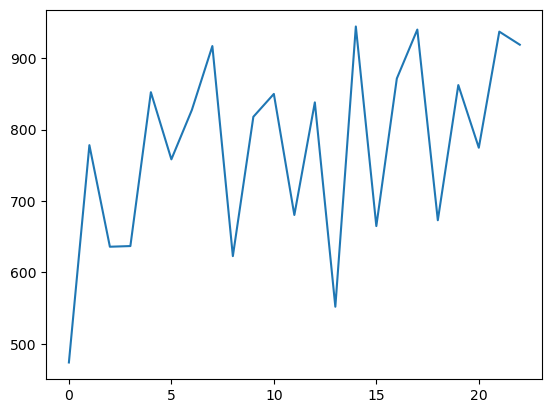

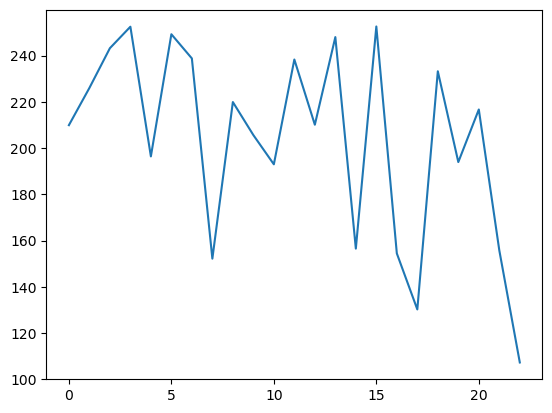

epoch 24
Track generation: 989..1248 -> 259-tiles track
score: 1033.499999999996
Track generation: 1004..1259 -> 255-tiles track
score: 923.0629921259756
Track generation: 1153..1445 -> 292-tiles track
score: 1029.5999999999851
Track generation: 883..1113 -> 230-tiles track
score: 1041.7999999999904
Track generation: 1134..1421 -> 287-tiles track
score: 904.1139860139707
Track generation: 1179..1485 -> 306-tiles track
score: 787.7672131147398
Track generation: 1200..1504 -> 304-tiles track
score: 1023.7999999999923
Track generation: 1166..1462 -> 296-tiles track
score: 1025.299999999988
Track generation: 1213..1521 -> 308-tiles track
score: 891.6986970683841
Track generation: 1143..1433 -> 290-tiles track
score: 1032.5999999999945
Dataset size: 25239
[001/010] 7.97 sec(s) Train Loss: 0.000015 | Val loss: 0.000013
[002/010] 7.78 sec(s) Train Loss: 0.000014 | Val loss: 0.000014
[003/010] 7.84 sec(s) Train Loss: 0.000013 | Val loss: 0.000014
[004/010] 8.02 sec(s) Train Loss: 0.000013 | Va

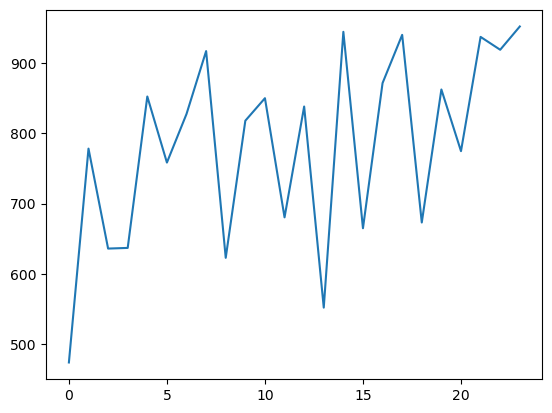

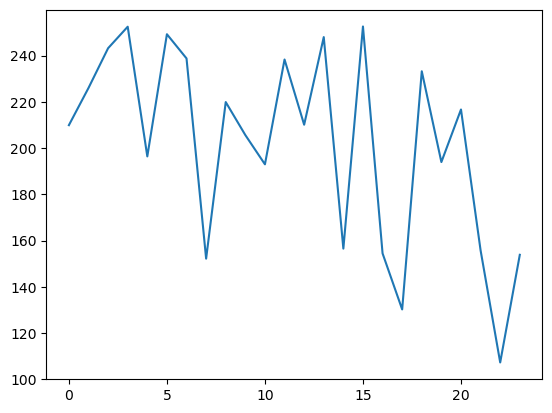

epoch 25
Track generation: 1137..1431 -> 294-tiles track
score: 1027.4999999999845
Track generation: 1354..1696 -> 342-tiles track
score: 988.2697947213843
Track generation: 1160..1454 -> 294-tiles track
score: 909.7481228668773
Track generation: 1001..1264 -> 263-tiles track
score: 913.9832061068608
Track generation: 1148..1446 -> 298-tiles track
score: 1021.4999999999856
Track generation: 1148..1439 -> 291-tiles track
score: 1033.5999999999876
Track generation: 1147..1438 -> 291-tiles track
score: 1031.199999999987
Track generation: 1249..1566 -> 317-tiles track
score: 895.2063291139137
Track generation: 1191..1493 -> 302-tiles track
score: 1027.2999999999936
Track generation: 1260..1579 -> 319-tiles track
score: 862.1748427672745
Dataset size: 26251
[001/010] 8.54 sec(s) Train Loss: 0.000015 | Val loss: 0.000014
[002/010] 8.26 sec(s) Train Loss: 0.000014 | Val loss: 0.000016
[003/010] 8.33 sec(s) Train Loss: 0.000013 | Val loss: 0.000015
[004/010] 8.63 sec(s) Train Loss: 0.000014 | 

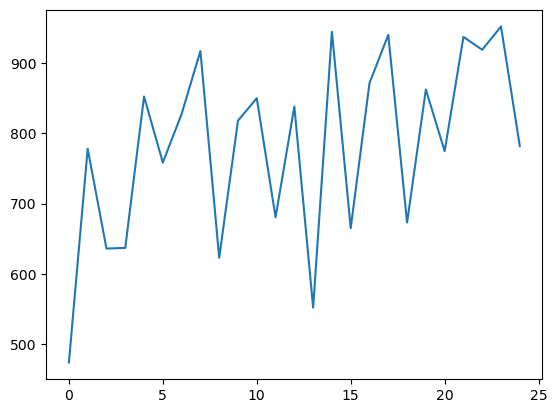

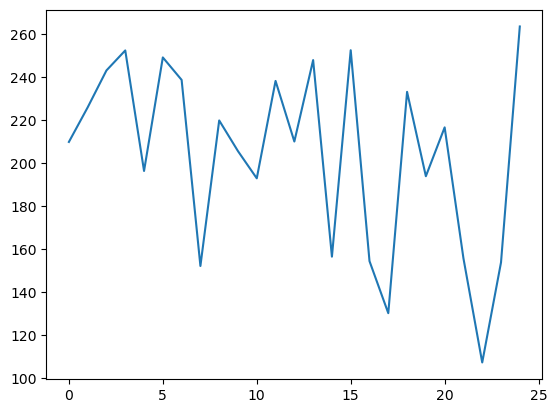

epoch 26
Track generation: 1100..1379 -> 279-tiles track
score: 1035.699999999987
Track generation: 1215..1523 -> 308-tiles track
score: 1025.4999999999823
Track generation: 992..1249 -> 257-tiles track
score: 1033.3999999999903
Track generation: 1059..1328 -> 269-tiles track
score: 1035.299999999988
Track generation: 1248..1564 -> 316-tiles track
score: 909.7253968253784
Track generation: 1108..1389 -> 281-tiles track
score: 898.0428571428406
Track generation: 1014..1273 -> 259-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1264..1584 -> 320-tiles track
score: 752.3557993730245
Track generation: 1112..1394 -> 282-tiles track
score: 1027.3999999999896
Track generation: 1152..1444 -> 292-tiles track
score: 1026.2999999999843
Track generation: 1055..1331 -> 276-tiles track
score: 915.427272727259
Dataset size: 27189
[001/010] 8.57 sec(s) Train Loss: 0.000014 | Val loss: 0.000013
[002/010] 8.75 sec(s) Train Loss: 0.000013 | Va

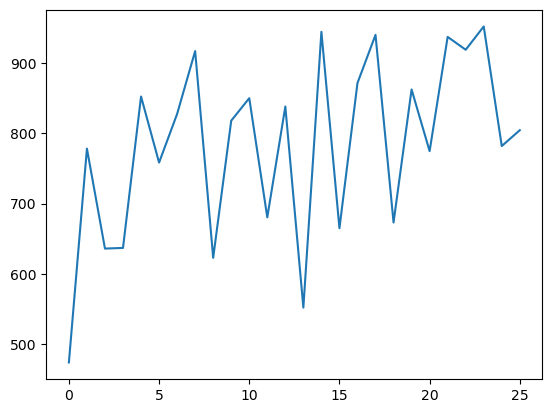

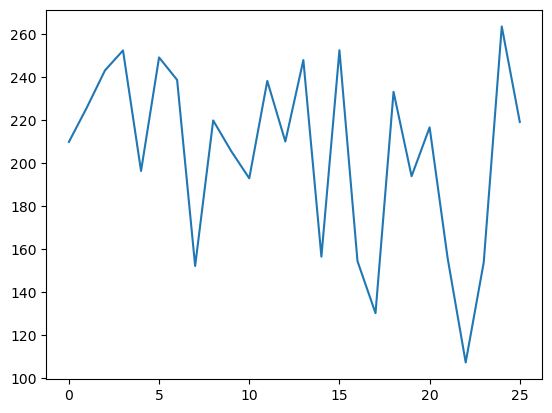

epoch 27
Track generation: 1072..1344 -> 272-tiles track
score: 1033.0999999999935
Track generation: 1343..1683 -> 340-tiles track
score: 988.2005899704914
Track generation: 1192..1494 -> 302-tiles track
score: 883.9219269102884
Track generation: 1200..1504 -> 304-tiles track
score: 883.3970297029604
Track generation: 1167..1463 -> 296-tiles track
score: 1030.0999999999892
Track generation: 1161..1454 -> 293-tiles track
score: 1027.4999999999845
Track generation: 993..1252 -> 259-tiles track
score: 1036.2999999999965
Track generation: 1240..1554 -> 314-tiles track
score: 884.9408945686769
Track generation: 1272..1594 -> 322-tiles track
score: 888.2084112149313
Track generation: 1151..1443 -> 292-tiles track
score: 882.2357388315975
Dataset size: 28212
[001/010] 8.66 sec(s) Train Loss: 0.000015 | Val loss: 0.000014
[002/010] 9.21 sec(s) Train Loss: 0.000014 | Val loss: 0.000014
[003/010] 9.18 sec(s) Train Loss: 0.000014 | Val loss: 0.000018
[004/010] 8.66 sec(s) Train Loss: 0.000013 | V

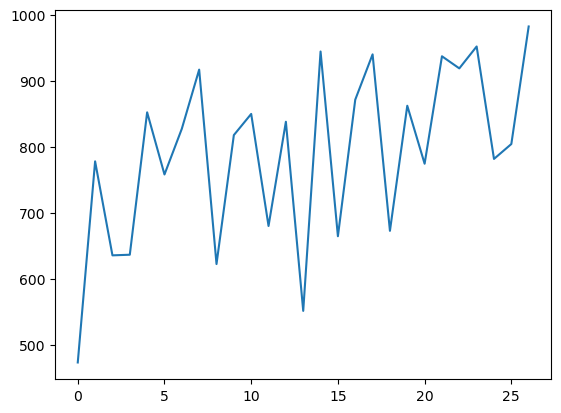

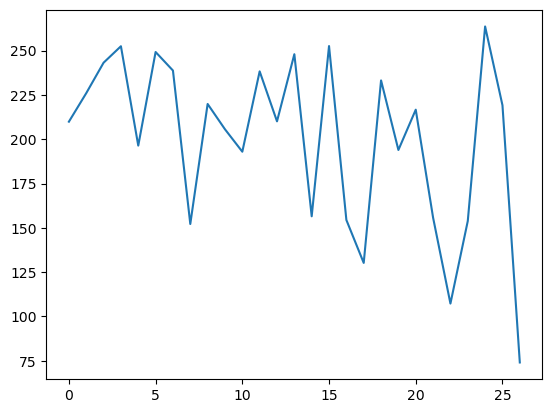

epoch 28
Track generation: 1051..1318 -> 267-tiles track
score: 1039.299999999987
Track generation: 1251..1570 -> 319-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1173..1470 -> 297-tiles track
score: 902.3864864864673
Track generation: 1012..1269 -> 257-tiles track
score: 894.9999999999882
Track generation: 1175..1473 -> 298-tiles track
score: 1026.3999999999855
Track generation: 1164..1460 -> 296-tiles track
score: 1023.6999999999877
Track generation: 1160..1454 -> 294-tiles track
score: 897.5092150170475
Track generation: 1123..1408 -> 285-tiles track
score: 1034.5999999999858
Track generation: 1342..1691 -> 349-tiles track
score: 1007.3999999999897
Track generation: 1167..1463 -> 296-tiles track
score: 1028.8999999999887
Track generation: 1011..1268 -> 257-tiles track
score: 1041.5999999999917
Dataset size: 29133
[001/010] 9.52 sec(s) Train Loss: 0.000014 | Val loss: 0.000015
[002/010] 9.15 sec(s) Train Loss: 0.000013 

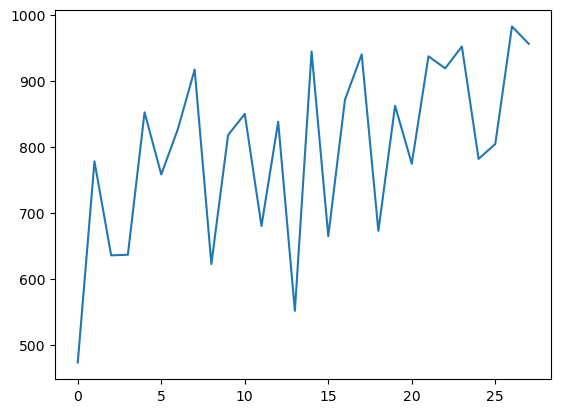

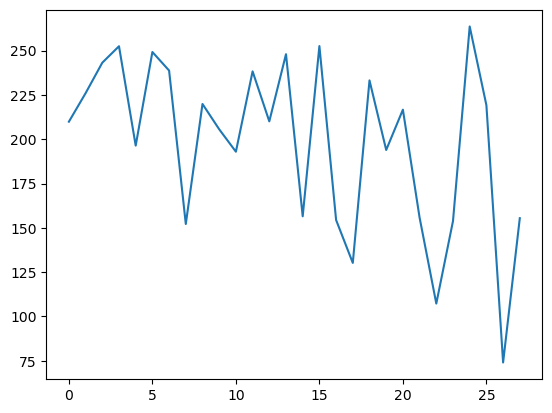

epoch 29
Track generation: 1270..1592 -> 322-tiles track
score: 897.6389408099477
Track generation: 1072..1344 -> 272-tiles track
score: 1035.699999999994
Track generation: 1231..1543 -> 312-tiles track
score: 1019.4999999999859
Track generation: 1175..1473 -> 298-tiles track
score: 908.7989898989737
Track generation: 1047..1313 -> 266-tiles track
score: 917.8792452830108
Track generation: 1135..1423 -> 288-tiles track
score: 1028.7999999999888
Track generation: 1115..1398 -> 283-tiles track
score: 1032.3999999999917
Track generation: 1162..1452 -> 290-tiles track
score: 322.0615916954992
Track generation: 1313..1645 -> 332-tiles track
score: 975.8308157099499
Track generation: 1257..1575 -> 318-tiles track
score: 1021.3999999999903
Dataset size: 30017
[001/010] 9.41 sec(s) Train Loss: 0.000014 | Val loss: 0.000014
[002/010] 9.29 sec(s) Train Loss: 0.000013 | Val loss: 0.000013
[003/010] 9.23 sec(s) Train Loss: 0.000013 | Val loss: 0.000014
[004/010] 9.26 sec(s) Train Loss: 0.000013 | 

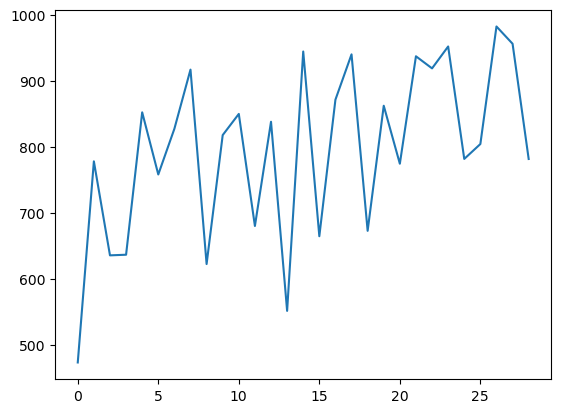

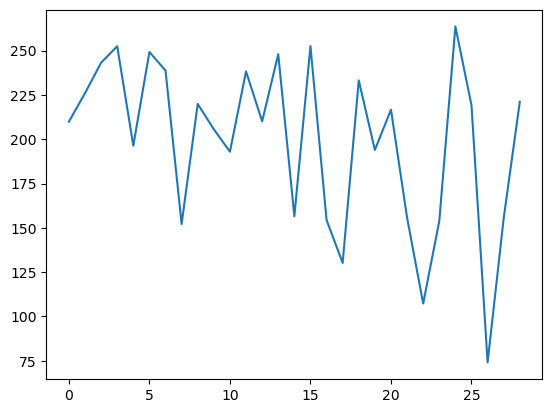

epoch 30
Track generation: 1211..1518 -> 307-tiles track
score: 889.7921568627236
Track generation: 1068..1342 -> 274-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1067..1338 -> 271-tiles track
score: 1036.599999999989
Track generation: 1199..1503 -> 304-tiles track
score: 899.098349834974
Track generation: 874..1101 -> 227-tiles track
score: 1044.5999999999901
Track generation: 1108..1399 -> 291-tiles track
score: 1028.6999999999873
Track generation: 1206..1511 -> 305-tiles track
score: 1025.399999999987
Track generation: 1087..1363 -> 276-tiles track
score: 904.8545454545301
Track generation: 1180..1479 -> 299-tiles track
score: 898.6214765100499
Track generation: 1089..1369 -> 280-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1092..1369 -> 277-tiles track
score: 1037.599999999995
Track generation: 1172..1469 -> 297-tiles track
score: 1023.3999999999826
Data

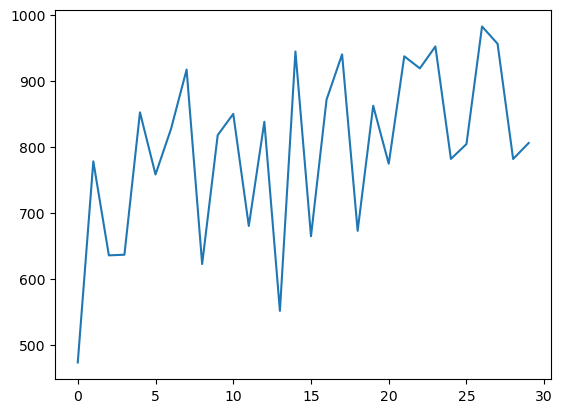

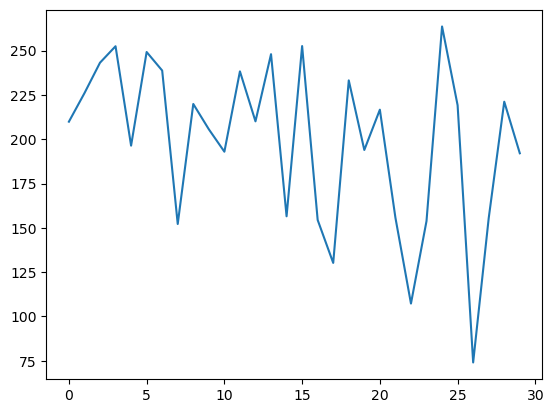

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

agent = Agent()
agent.load_param()

model = Classifier().cuda()

env = Env()

X = []
Y = []
test_mean = []
test_std = []

epoch = 30

my_prob = list()
for i_ep in range(1, epoch+1):
    print('epoch {}'.format(i_ep))
    
    # get trajectory
    T = 10 if i_ep != 1 else 30
    for _ in range(T):
        score = 0
        state = env.reset()
        tmp_X, tmp_Y = [], []
        for t in range(1000):
            action = agent.select_action(state)
            state_, reward, done, die = env.step(action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))

            tmp_X.append(state)
            tmp_Y.append(action)
            
            # env.render()
            score += reward
            state = state_
            if done or die:
                break
        print("score: {}".format(score))
        
        if score > 600:
            for x in tmp_X:
                X.append(x)
            for y in tmp_Y:
                Y.append(y)
        
    env.close()
    print("Dataset size: {}".format(len(X)))
    
    # train new policy
    # model = Classifier().cuda()  
    
    seed = np.random.randint(0, 10000)
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(Y)
    
    train_x, val_x= X[:math.floor(len(X)*0.8)], X[math.floor(len(X)*0.8):]
    train_y, val_y= Y[:math.floor(len(Y)*0.8)], Y[math.floor(len(Y)*0.8):]
    batch_size = 128
    train_set = ImgDataset(train_x, train_y)
    val_set = ImgDataset(val_x, val_y)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
            
    loss = nn.MSELoss().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
    num_train_epoch = 10 if i_ep != 1 else 50
      
    for train_epoch in range(num_train_epoch):
        epoch_start_time = time.time()
        train_loss = 0.0
        val_loss = 0.0

        model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
        for i, data in enumerate(train_loader):
            optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
            train_pred = model(data[0].cuda().float())
            batch_loss = loss(train_pred, data[1].cuda()).cuda() # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
            batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
            optimizer.step() # 以 optimizer 用 gradient 更新參數值

            train_loss += batch_loss.item()

        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                val_pred = model(data[0].cuda().float())
                batch_loss = loss(val_pred, data[1].cuda())
                val_loss += batch_loss.item()

            #將結果 print 出來
            print('[%03d/%03d] %2.2f sec(s) Train Loss: %3.6f | Val loss: %3.6f' % \
                (train_epoch + 1, num_train_epoch, time.time()-epoch_start_time, train_loss/train_set.__len__(), val_loss/val_set.__len__()))
    
    # test policy
    num_test_epoch = 50
    total_score = 0
    scores = []
    for test_epoch in range(1, num_test_epoch+1):
        score = 0
        state = env.reset()
        
        for t in range(1000):
            action = model(torch.tensor(state.reshape(1,4,96,96)).cuda().float())[0]
            action = action.cpu().detach().numpy()

            state_, reward, done, die = env.step(action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))
            # env.render()
            score += reward
            state = state_
            if done or die:
                break
    
        total_score += score
        scores.append(score)
        
        mean = np.array(scores).mean()
        std = np.array(scores).std()
        print("Epoch: {}".format(test_epoch))
        print('BC\tmean: {:.2f}\tvariance: {:.2f}'.format(mean, std))
    
    test_mean.append(mean)
    test_std.append(std)
    
    torch.save(model, 'BC_model/BC_model{}.pt'.format(i_ep))
    
    plt.figure()
    plt.plot(test_mean)
    plt.figure()
    plt.plot(test_std)
    plt.show()
        
    env.close()

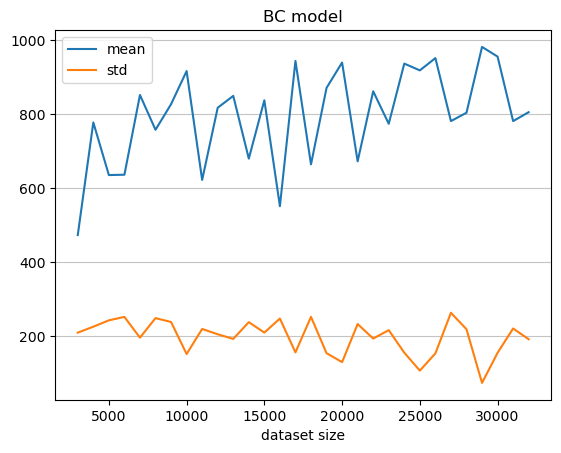

In [12]:
# np.save('./BC_model/mean.npy', test_mean)
# np.save('./BC_model/std.npy', test_std)

means = np.load('./BC_model/mean.npy')
stds = np.load('./BC_model/std.npy')

x_value = [3000+i*1000 for i in range(30)]

plt.figure()

l1 = plt.plot(x_value, means)[0]
l2 = plt.plot(x_value, stds)[0]

plt.grid(axis='y', alpha=0.75)
plt.xlabel('dataset size')
plt.title('BC model')
plt.legend(handles=[l1, l2], labels=['mean', 'std'])

plt.show()